# JLD2 to CSV
This script convets `.jld2` files output from `PorousMaterials.jl`'s `gcmc_simulation` function and compiles them into a `.csv` file which can then be imported into a DataFrame.

In [1]:
using PorousMaterials
using FileIO
# using JLD2
using CSV
using DataFrames
using PyPlot

┌ Info: Precompiling PorousMaterials [68953c7c-a3c7-538e-83d3-73516288599e]
└ @ Base loading.jl:1273


**TODO:**
* consider renaming to "gcmc_results_to_dataframe" 
* should we have this write the dataframe file directly to the gcmc_sims directory?
* make input arguements iinto a dictionary (possibly accept as commandline arguments)

In [2]:
pressures = 10 .^ range(-2, stop=log10(300), length=15)
frameworks = ["COF-102", "COF-103"]
PorousMaterials.PATH_TO_DATA

"/home/simoncor/PropellantStorage/data"

In [3]:
function isotherm_sim_results_to_dataframe(props_we_want::Array{String},
        frameworkname::String, gas::Symbol, forcefieldname::String, temperature::Float64, 
        pressures::Array{Float64}, n_burn_cycles::Int, n_sample_cycles::Int; 
        where_are_jld_files::Union{String, Nothing}=nothing)
    
    if isnothing(where_are_jld_files)
        where_are_jld_files = joinpath(PorousMaterials.PATH_TO_DATA, "gcmc_sims")
    end
    
    # prepare dataframe to populate
    df = DataFrame()
    for col in props_we_want
        insertcols!(df, length(names(df)) + 1, Symbol(col) => Float64[])
    end

    for (i, pressure) in enumerate(pressures)
        sim_result = load(
            joinpath(where_are_jld_files, 
                gcmc_result_savename(frameworkname, gas, forcefieldname, 
                    temperature, pressure, n_burn_cycles, n_sample_cycles) * ".jld2"
            ), "results"
        )
        push!(df, [sim_result[prop] for prop in props_we_want])
    end
    return df
    
end

isotherm_sim_results_to_dataframe (generic function with 1 method)

In [6]:
cof_to_isotherm = Dict{String, DataFrame}() # must be defined outside of the function if you want to plot

props_we_want = ["pressure (bar)", "fugacity (bar)", "⟨N⟩ (mmol/g)"]
for frameworkname in frameworks
    cof_to_isotherm[frameworkname] = isotherm_sim_results_to_dataframe(props_we_want, frameworkname,
        :Xe, "Dreiding", 298.0, pressures, 25000, 25000)
    CSV.write(joinpath("data", "sim_xe_isotherms", frameworkname * ".csv"), df)
end
cof_to_isotherm

Dict{String,DataFrame} with 2 entries:
  "COF-102" => 15×3 DataFrame…
  "COF-103" => 15×3 DataFrame…

In [7]:
cof_to_isotherm["COF-102"]

,pressure (bar),fugacity (bar),⟨N⟩ (mmol/g)
,Float64,Float64,Float64
1,0.01,0.0099994,0.0235648
2,0.0208831,0.0208804,0.048849
3,0.0436103,0.0435988,0.101344
4,0.0910716,0.0910217,0.215283
5,0.190186,0.189968,0.462062
6,0.397166,0.396216,0.995574
7,0.829404,0.825265,2.30134
8,1.73205,1.71403,6.05594
9,3.61705,3.53871,17.2732


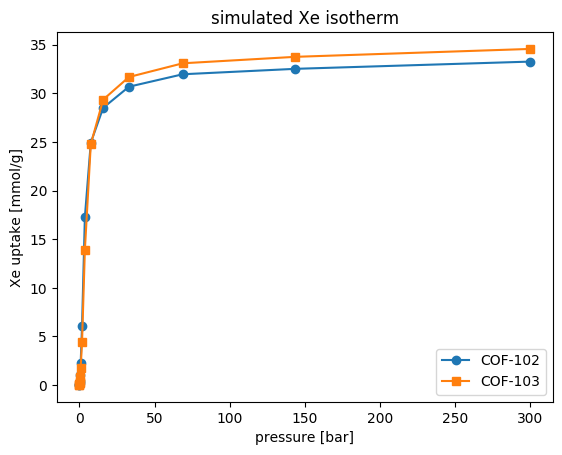

PyObject Text(0.5, 1, 'simulated Xe isotherm')

In [12]:
figure()
cof_to_marker = Dict(zip(frameworks, ["o", "s"]))
for cof in frameworks
    plot(cof_to_isotherm[cof][:, Symbol("pressure (bar)")], 
         cof_to_isotherm[cof][:, Symbol("⟨N⟩ (mmol/g)")], 
        label=cof, marker=cof_to_marker[cof])
end
legend()
xlabel("pressure [bar]")
ylabel("Xe uptake [mmol/g]")
title("simulated Xe isotherm")

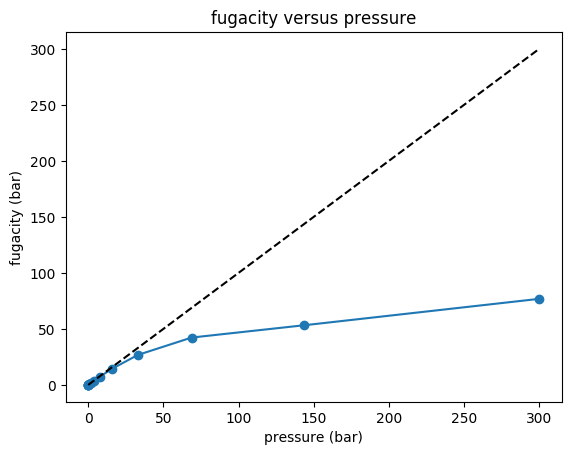

PyObject Text(0.5, 1, 'fugacity versus pressure')

In [18]:
figure()
plot(cof_to_isotherm["COF-102"][:, Symbol("pressure (bar)")], cof_to_isotherm["COF-102"][:, Symbol("fugacity (bar)")], marker="o")
plot([0, 300], [0, 300], color="k", linestyle="--")
xlabel("pressure (bar)")
ylabel("fugacity (bar)")
title("fugacity versus pressure")

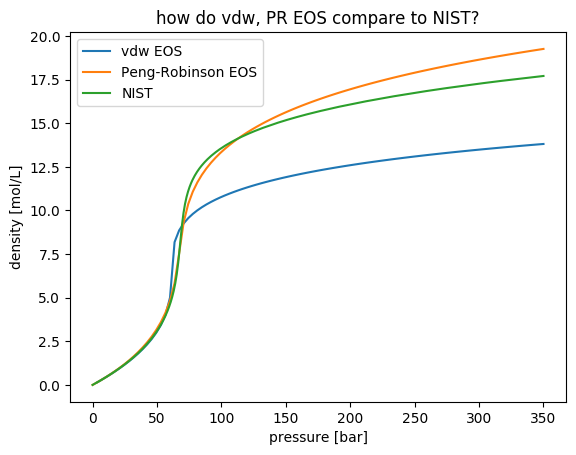

PyObject <matplotlib.legend.Legend object at 0x7f50d3d99240>

In [32]:
wheres_nist_xenon_data = joinpath("data", "NIST_data", "xenon_NIST_data.txt")

df_xe_data = CSV.read(wheres_nist_xenon_data)
p_plot = range(0.0, 350.0, length=100)
xe_vdw = VdWFluid(:Xe)
xe_pr = PengRobinsonFluid(:Xe)
ρ_vdw = [1.0 / calculate_properties(xe_vdw, 298.0, p, verbose=false)["molar volume (L/mol)"] for p in p_plot]
ρ_pr = [1.0 / calculate_properties(xe_pr, 298.0, p, verbose=false)["molar volume (L/mol)"] for p in p_plot]

figure()
plot(p_plot, ρ_vdw, label="vdw EOS")
plot(p_plot, ρ_pr, label="Peng-Robinson EOS")
plot(df_xe_data[:, Symbol("Pressure (bar)")], df_xe_data[:, Symbol("Density (mol/l)")], label="NIST")
xlabel("pressure [bar]")
ylabel("density [mol/L]")
title("how do vdw, PR EOS compare to NIST?")
legend()